by inês <3 doing my best

In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import pickle
import os
from stock_forecasting.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR, INTERIM_DATA_DIR
import gc

/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. XGBoost

In [2]:
df = pd.read_pickle("../../extra_features.pkl")

In [26]:
y = df.xs("Target", level='Price', axis=1).shift(-1).dropna()
X = df.loc[:, ~df.columns.get_level_values(1).isin(["Target"])]

When determining the optimal training size for time series forecasting, a key consideration is the balance between the amount of historical data and the ability of the model to generalize effectively. Commonly, a "window size" is chosen, which refers to the number of past observations used to train a model before predicting future points. Research suggests that for time series data, particularly in volatile and unpredictable contexts, using a larger window (e.g., 70% of the data) can improve model performance as it captures enough historical context, but care must be taken to avoid overfitting to past patterns. For example, one approach using a sliding window technique with a 70% training size has been applied successfully, where data is divided into a training set and a test set based on this proportion.

Furthermore, some studies suggest that using cross-validation methods like Time Series Split or Sliding Window cross-validation can provide better insights into model performance across different segments of the data. These methods test the model on multiple, time-sensitive segments and can help determine whether increasing the training size (or adjusting the window) consistently leads to improved predictions.

In terms of practical implementation, experimenting with different window sizes (e.g., 60%, 70%, 80%) and horizons (e.g., predicting 5-day or 10-day ahead) is advised. Testing this across multiple time periods can also help ensure robustness, especially for volatile financial markets or stock prices.

In [3]:
models_dir = "../../models"

In [28]:
results_xgboost = []

In [29]:
def time_series_cv(X, y, ticker, train_size=0.9, horizon=5):
    n = len(y)
    train_len = int(n * train_size)
    
    results = []
    ticker_dir = os.path.join(models_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)

    idx = 0
    # Iterate through the dataset to create folds
    for start_idx in range(0, n - train_len - horizon + 1, horizon):
        train_end_idx = start_idx + train_len
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + horizon

        # Split X and y into training and testing sets
        train_X = X.iloc[start_idx:train_end_idx]
        train_y = y.iloc[start_idx:train_end_idx]
        test_X = X.iloc[test_start_idx:test_end_idx]
        test_y = y.iloc[test_start_idx:test_end_idx]

        # Retrieve start and end dates from the index
        train_start_date = train_X.index[0]
        train_end_date = train_X.index[-1]
        test_start_date = test_X.index[0]
        test_end_date = test_X.index[-1]

        print(f"  Training: {train_start_date} to {train_end_date}")
        print(f"  Testing: {test_start_date} to {test_end_date}")


        # Initialize scalers
        scaler = RobustScaler()
        
        # Fit scaler on train data and transform train and test data
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        #print(scaler.feature_names_in_)

        # Fit model on scaled data
        model = XGBRegressor()
        model.fit(train_X, train_y)

        model_path = os.path.join(ticker_dir, f"model_{idx}.pkl")
        scaler_path = os.path.join(ticker_dir, f"scaler_{idx}.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
            print(f"Model for {ticker}, fold {idx}, saved at {model_path}.")

        with open(scaler_path, "wb") as f:
            pickle.dump(scaler, f)

        # Predict and evaluate performance
        predictions = model.predict(test_X)
        error = mean_squared_error(test_y, predictions)
        r2 = r2_score(test_y, predictions)
        print(f"  Error: {error:.4f}")

        # Save fold results
        results.append({
            "train_start_date": train_start_date,
            "train_end_date": train_end_date,
            "test_start_date": test_start_date,
            "test_end_date": test_end_date,
            "mse": error,
            "r2_score": r2
        })

        idx += 1

    # Calculate mean target value and overall error statistics
    mean_error = np.mean([r["mse"] for r in results])
    std_error = np.std([r["mse"] for r in results])
    mean_r2 = np.mean([r["r2_score"] for r in results])
    std_r2 = np.std([r["r2_score"] for r in results])

    # Feature importance from XGBoost
    feature_importances = model.feature_importances_

    # Summary results
    summary = {
        "ticker": ticker,
        "mean_error": mean_error,
        "std_error": std_error,
        "feature_importances": feature_importances,
        "mean_r2": mean_r2,
        "std_r2": std_r2
    }
        
    
    return summary

In [4]:
tickers = df.columns.get_level_values("Ticker").unique()
tickers

Index(['HAL', 'K', 'IRM', 'HES', 'KEY', 'DGX', 'TER', 'YUM', 'GRMN', 'ARE',
       ...
       'IPG', 'CMI', 'EA', 'MSCI', 'SCHW', 'DLR', 'DD', 'SWK', 'MSFT', 'ROK'],
      dtype='object', name='Ticker', length=392)

In [ ]:
for ticker in tickers:
    df_example = df.xs(str(ticker), level='Ticker', axis=1)
    X = df_example.drop(columns='Target')
    y = df_example['Target'].shift(-1).dropna()
    results_xgboost.append(time_series_cv(X,y,ticker))

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results_xgboost)

# Save to CSV
results_df.to_csv("../results_xgboost.csv", index=False)

print("Results saved to 'results_xgboost.csv'")

Results saved to 'results_xgboost.csv'


In [ ]:
df_results = pd.read_csv("../results_xgboost.csv")
df_results

,ticker,mean_error,std_error,feature_importances,mean_r2,std_r2
0,HAL,0.000728,0.000629,[0.06068382 0.10095634 0.09928608 0.09795073 0...,-0.945768,1.076826
1,HAL,0.000728,0.000629,[0.06068382 0.10095634 0.09928608 0.09795073 0...,-0.945768,1.076826
2,HAL,0.000728,0.000629,[0.06068382 0.10095634 0.09928608 0.09795073 0...,-0.945768,1.076826
3,K,0.000193,0.000251,[0.07770465 0.10641241 0.09809376 0.10639818 0...,-1.837969,3.156360
4,IRM,0.000358,0.000262,[0.07301872 0.07182811 0.1070925 0.11120194 0...,-2.449012,7.852735
...,...,...,...,...,...,...
484,DLR,0.000572,0.000706,[0.0729652 0.08447772 0.1155431 0.08530357 0...,-0.978336,1.685594
485,DD,0.000352,0.000590,[0.0624507 0.07954553 0.10368954 0.10799032 0...,-1.112393,1.456871
486,SWK,0.000750,0.000683,[0.08155386 0.07276819 0.10632821 0.10341518 0...,-1.974194,4.852029
487,MSFT,0.000381,0.000419,[0.09087383 0.0737491 0.11030757 0.09918408 0...,-0.657018,1.038034


---

Lower MSE

In [ ]:
min_mse_index = df_results['mean_error'].idxmin()
best_result = df_results.loc[min_mse_index]
best_result

ticker                                                               MCD
mean_error                                                      0.000164
std_error                                                       0.000188
feature_importances    [0.09035295 0.09420938 0.14845616 0.0870756  0...
mean_r2                                                        -3.543118
std_r2                                                         13.451254
Name: 154, dtype: object

In [ ]:
best_result['feature_importances']

'[0.09035295 0.09420938 0.14845616 0.0870756  0.10237906 0.0785903\n 0.10102529 0.08746072 0.09580383 0.11464667 0.        ]'

In [ ]:
feature_importances_str = best_result['feature_importances']

# Replace multiple spaces with a single space
cleaned_str = re.sub(r"\s+", " ", feature_importances_str)

# Replace spaces between numbers with commas
corrected_str = cleaned_str.replace(" ", ", ")

# Use ast.literal_eval to convert it into a Python list
feature_importances = ast.literal_eval(corrected_str)

print("Feature Importances:", feature_importances)

Feature Importances: [0.09035295, 0.09420938, 0.14845616, 0.0870756, 0.10237906, 0.0785903, 0.10102529, 0.08746072, 0.09580383, 0.11464667, 0.0]


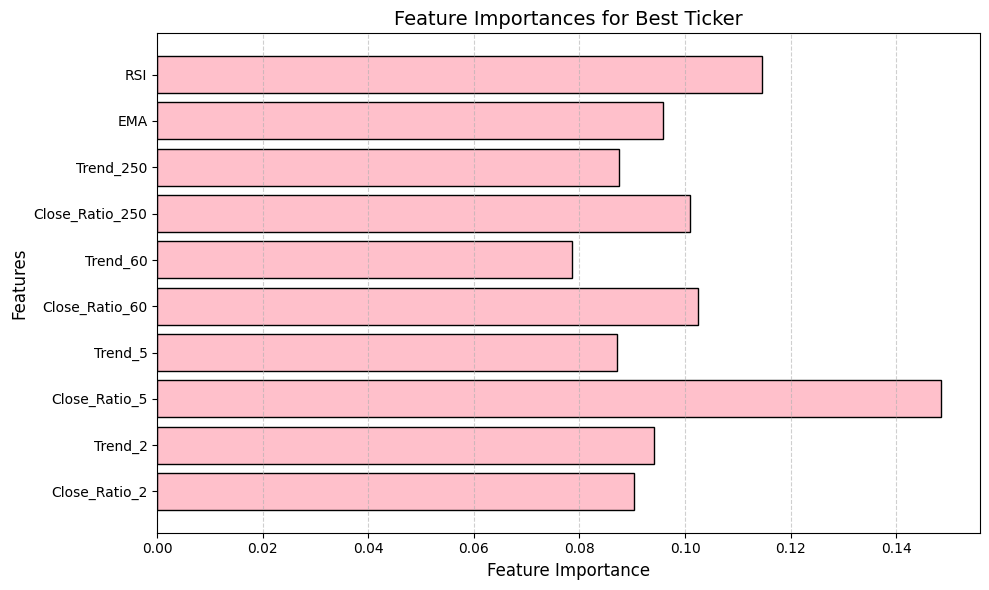

In [ ]:
# Example feature names
feature_names = ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
                 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 
                 'EMA', 'RSI']

# Example feature importances from your best result
feature_importances = feature_importances[:-1]

# Create a barplot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='pink', edgecolor='black')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importances for Best Ticker', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()


### Ensemble

In [8]:
def ensemble(ticker_dir, models_dir):
    #ensemble_models = {}

    ticker_path = os.path.join(models_dir, ticker_dir)

    if os.path.isdir(ticker_path):
        models = []

        for model_file in os.listdir(ticker_path):
            if model_file.endswith('.pkl') and not model_file.startswith('scaler_'):
                model_path = os.path.join(ticker_path, model_file)
                with open(model_path, 'rb') as f:
                    model = pickle.load(f)
                    models.append((model_file, model))

        ensemble_model = VotingRegressor(estimators=models)
        result = ensemble_model.estimators[0][0]
        print(f"Ensemble Model for ticker {ticker_dir} created")


        del models
        del ensemble_model
        gc.collect()

    return result

In [9]:
ensemble_models = {}

In [ ]:
for ticker in tickers:
    ensemble_models[str(ticker)] = ensemble(ticker, models_dir)

### Predict

In [19]:
def predict_xgb(X_test, ticker):
    model_file = ensemble_models[str(ticker)]
    model_path = os.path.join(f'../../models/{ticker}', model_file)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    idx = model_file.split('_')[1].split('.')[0]
    scaler_file = f"scaler_{idx}.pkl"
    scaler_path = os.path.join(f'../../models/{ticker}', scaler_file)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    X_scaled = scaler.transform(X_test)
    predictions = model.predict(X_scaled)
    
    return predictions

In [12]:
def true_labels_xgb(y_test):
    res = []
    for label in y_test:
        res.append(label)
    return res

In [22]:
def get_test_data_for_ticker(df, ticker, target_column="Target"):
    """
    Extract test data for a specific ticker and a given date range.

    Args:
        df (pd.DataFrame): The full dataset with tickers as part of the column hierarchy or labels.
        ticker (str): The ticker for which to extract data.
        target_column (str): The name of the target column.
        test_start (str): Start date for the test set (YYYY-MM-DD).
        test_end (str): End date for the test set (YYYY-MM-DD).

    Returns:
        X_test (pd.DataFrame): Feature data for the ticker in the test period.
        y_test (pd.Series): Target data for the ticker in the test period.
    """
    # Select data for the specific ticker
    df_ticker = df.xs(ticker, level="Ticker", axis=1)
    #print(df_ticker)

    # Filter by date range
    test_df = df_ticker[df_ticker.index >= '2024-01-01']
    #print(len(test_df))
    #print(test_df)

    # Separate features and target
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column].shift(-1).dropna()

    return X_test, y_test


In [14]:
def get_test_data_for_ticker_by_index(df, ticker, test_start, test_end, target_column="Target"):
    # Select data for the specific ticker
    df_ticker = df.xs(ticker, level="Ticker", axis=1)
    #print(df_ticker)

    # Filter by date range
    test_df = df_ticker.iloc[test_start:test_end+1]
    #print(test_df)

    # Separate features and target
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column].shift(-1).dropna()

    return X_test, y_test


In [15]:
filtered_df = pd.read_pickle(PROCESSED_DATA_DIR / "filtered.pkl")
filtered_df = filtered_df[filtered_df.index >= "2023-12-29"]
true_prices = filtered_df.xs('Close', level='Price', axis=1)
true_prices

Ticker,HAL,K,IRM,HES,KEY,DGX,TER,YUM,GRMN,ARE,...,IPG,CMI,EA,MSCI,SCHW,DLR,DD,SWK,MSFT,ROK
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 00:00:00+00:00,35.590893,54.450523,68.478699,142.745651,13.822551,134.977219,108.196030,128.731277,126.783714,122.739380,...,31.633408,235.239120,136.257370,559.151062,67.795845,131.346115,75.807732,95.541183,373.995972,304.780853
2024-01-02 00:00:00+00:00,35.561352,56.252228,67.157661,143.359543,14.024131,137.855331,104.457230,127.125343,124.830772,125.198616,...,32.079220,236.819992,135.231537,549.414124,68.091469,131.980484,76.379280,95.638573,368.854095,300.756134
2024-01-03 00:00:00+00:00,36.004391,55.979542,64.799362,146.359833,13.611374,136.739319,101.446236,127.194336,122.453705,121.364525,...,31.129442,233.422546,135.161819,543.552368,66.071388,130.301819,75.896423,91.645523,368.585571,298.282318
2024-01-04 00:00:00+00:00,35.226608,55.356247,65.132072,144.320038,13.755358,137.600800,101.276749,126.790367,122.118347,121.674355,...,31.197285,231.615814,135.420776,553.289124,65.913719,128.613388,75.443123,91.859787,365.940002,299.077515
2024-01-05 00:00:00+00:00,35.413673,55.180946,65.318001,143.636810,14.052927,138.990906,102.463196,126.445534,121.171463,122.487648,...,31.439573,233.854599,135.062225,531.868103,66.248764,127.686218,75.571243,93.018745,365.751038,299.450500
2024-01-08 00:00:00+00:00,34.665428,55.064079,66.590103,142.448578,14.110520,138.618912,105.573883,126.741104,121.339142,125.624634,...,32.205212,236.810181,135.908798,536.909485,66.810448,130.487244,75.551529,95.287971,372.653351,300.441956
2024-01-09 00:00:00+00:00,33.976254,54.917992,65.699631,138.794785,14.004932,139.118164,104.925819,126.327301,120.214714,124.259460,...,31.895077,235.081985,137.163696,533.548645,65.775764,130.409164,75.196777,94.995796,373.747375,297.408722
2024-01-10 00:00:00+00:00,33.543056,54.333656,65.738770,137.557037,13.880145,134.213654,104.566895,127.292839,121.566002,125.024345,...,31.575260,234.895416,137.074066,540.379211,64.859337,133.249252,75.068672,95.609367,380.689392,296.525208
2024-01-11 00:00:00+00:00,33.661205,53.807751,64.828720,138.418518,13.812953,132.911652,104.786240,127.095787,121.496956,121.868004,...,31.497725,233.265427,137.183609,543.957642,64.307510,130.780045,74.654800,94.362747,382.539307,299.499603


Predicted Close Price = ( 1 + predicted price change ) * real close price from the day before

In [16]:
def predicted_close_price(true_prices, predictions):# Calculate predicted close price
    orig = true_prices.sort_index(axis=1)
    result = np.zeros_like(orig)
    for i in range(0, len(orig), 5):
        prev = orig.iloc[i]
        for j in range(5):
            if i + j >= len(result):
                break
            result[i + j] = prev * (1 + predictions[i + j])
            prev = result[i + j]
    index = filtered_df[filtered_df.index >= '2024-01-01'].index
    result = pd.DataFrame(result, columns=true_prices.columns, index=index)
    return result

In [23]:
all_preds = pd.DataFrame()

In [ ]:
for ticker in tickers:
    X_test, y_test = get_test_data_for_ticker(df, ticker)
    predictions = predict_xgb(X_test, ticker)
    true_labels = true_labels_xgb(y_test)
    true_prices_ticker = true_prices[[str(ticker)]][:-1]
    pred = predicted_close_price(true_prices_ticker, predictions)
    all_preds = pd.concat([all_preds, pred], axis = 1)

In [31]:
all_preds.to_pickle(MODELS_DIR / 'predictions_xgb.pkl')

In [32]:
all_preds = pd.read_pickle(MODELS_DIR / 'predictions_xgb.pkl')
all_preds

Ticker,HAL,K,IRM,HES,KEY,DGX,TER,YUM,GRMN,ARE,...,IPG,CMI,EA,MSCI,SCHW,DLR,DD,SWK,MSFT,ROK
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00+00:00,35.783888,54.150266,66.539924,144.126702,13.506965,133.965027,105.489442,128.835231,125.054666,119.448116,...,30.871823,232.947248,136.404825,553.725863,65.942303,129.993715,75.515706,92.198743,373.303875,303.138905
2024-01-03 00:00:00+00:00,35.570119,53.560762,66.805953,143.066577,13.636869,134.915363,105.629757,128.523226,124.827383,119.977535,...,30.986807,231.174403,137.032847,563.079179,65.771842,128.480974,75.237804,92.430036,370.428024,304.636819
2024-01-04 00:00:00+00:00,35.653784,53.279528,67.209053,142.825967,13.872442,135.608708,106.300485,128.318321,124.159439,120.769074,...,31.103904,233.284061,136.654637,547.896743,65.964384,127.595602,75.347711,93.419499,370.306588,304.757895
2024-01-05 00:00:00+00:00,34.987766,53.145774,68.383068,142.846143,13.897431,135.115004,109.224031,128.356410,124.412269,123.527947,...,31.420349,235.388804,137.619410,552.805706,66.452445,130.184032,75.276119,95.429599,375.985800,305.431744
2024-01-08 00:00:00+00:00,34.701882,53.018035,67.557403,139.376951,13.756670,135.321463,108.533813,127.974260,123.662386,122.146177,...,31.197327,233.870547,137.849661,550.001152,65.448616,130.396986,74.980645,95.063556,377.213313,303.229794
2024-01-09 00:00:00+00:00,34.373899,54.524434,66.469975,141.465095,13.990987,134.350666,105.395882,127.102505,122.591732,126.238979,...,31.912581,236.439352,135.593459,542.685644,65.738599,132.872974,75.560364,95.702662,378.997950,300.205305
2024-01-10 00:00:00+00:00,34.435045,54.052355,65.425316,141.681426,13.927895,133.002660,105.336604,126.769218,122.618782,123.021736,...,31.815624,234.997481,135.496232,543.849474,65.075391,130.898058,75.147564,94.808812,381.249996,302.465020
2024-01-11 00:00:00+00:00,34.751247,54.151232,66.222818,142.736545,13.792023,132.192723,104.976089,126.936599,123.086799,123.400981,...,31.458814,234.152722,135.236857,540.870999,64.862608,133.378746,74.719362,93.731028,384.729036,302.466462
2024-01-12 00:00:00+00:00,34.310411,53.074127,65.163816,140.956747,13.563225,131.298691,104.702293,127.312176,122.362895,123.375025,...,31.356119,233.046104,134.634751,538.675756,63.945624,134.468626,73.311573,92.811456,386.664650,296.646929


In [ ]:
def plot_xgb_preds(X_test, predictions, true_labels):
    plt.figure(figsize=(12,8))
    
    plt.scatter(
        [i for i in range(len(predictions))],
        true_labels,
        color='pink',
        label='True Labels',
        edgecolors='k',
        s=200
    )

    plt.scatter(
        [i for i in range(len(predictions))],
        predictions,
        color='purple',
        label='Predictions',
        edgecolors='k',
        marker= 'x',
        s=200
    )

    plt.xlabel('Time [days]')
    plt.ylabel('Price Change')
    plt.title('True Labels vs Predictions')
    plt.axhline(0, color='red', linestyle=":", linewidth=2)  # To add a baseline

    # Displaying the legend
    plt.legend()
    plt.show()

In [ ]:
x_test.iloc[:-1, 0]

Date
2024-01-02 00:00:00+00:00    0.999585
2024-01-03 00:00:00+00:00    1.006191
2024-01-04 00:00:00+00:00    0.989081
2024-01-05 00:00:00+00:00    1.002648
2024-01-08 00:00:00+00:00    0.989323
Name: Close_Ratio_2, dtype: float64

/tmp/ipykernel_5566/2140540707.py:13: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


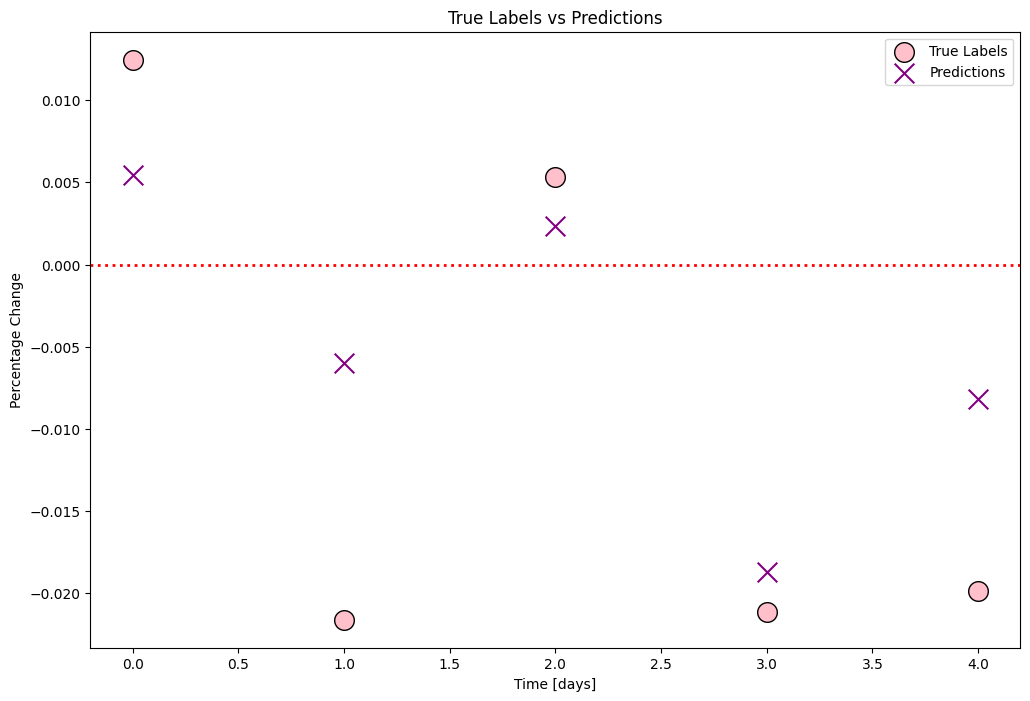

In [ ]:
plot_xgb_preds(x_test, predictions_HAL, true_labels_HAL)

---
### Other way ?


In [ ]:
specific_date = '2024-01-02 00:00:00+00:00'  # Example date
df_HAL = df.xs('HAL', level='Ticker', axis=1)
row_position = df_HAL.index.get_loc('2024-01-02 00:00:00+00:00')
print(f"The index for {specific_date} is {row_position}")

The index for 2024-01-02 00:00:00+00:00 is 3271


In [ ]:
def create_test_intervals(df, train_size_percentage=0.9, horizon=5):
    intervals = []
    train_size = int(len(df) * train_size_percentage)

    idx = 0

    for start_idx in range(0, int(len(df)) - train_size - horizon + 1, horizon):

        train_end_idx = start_idx + train_size
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + horizon

        if test_end_idx < len(df):  # Ensure the index is within range
            end_date = df.index[test_end_idx]
            if end_date.year == 2024:  # Filter intervals ending in 2024
                intervals.append((idx, test_start_idx, test_end_idx))
                    

        idx += 1
    
    return intervals

In [ ]:
intervals = create_test_intervals(df)
intervals

[(61, 3266, 3271), (62, 3271, 3276), (63, 3276, 3281), (64, 3281, 3286)]

In [ ]:
def predict_xgb_2(X_test, ticker, model_file):
    model_path = os.path.join(f'../../models/{ticker}', model_file)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    idx = model_file.split('_')[1].split('.')[0]
    scaler_file = f"scaler_{idx}.pkl"
    scaler_path = os.path.join(f'../../models/{ticker}', scaler_file)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    X_scaled = scaler.transform(X_test[:-1])
    predictions = model.predict(X_scaled)
    
    return predictions

/tmp/ipykernel_5566/2140540707.py:13: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


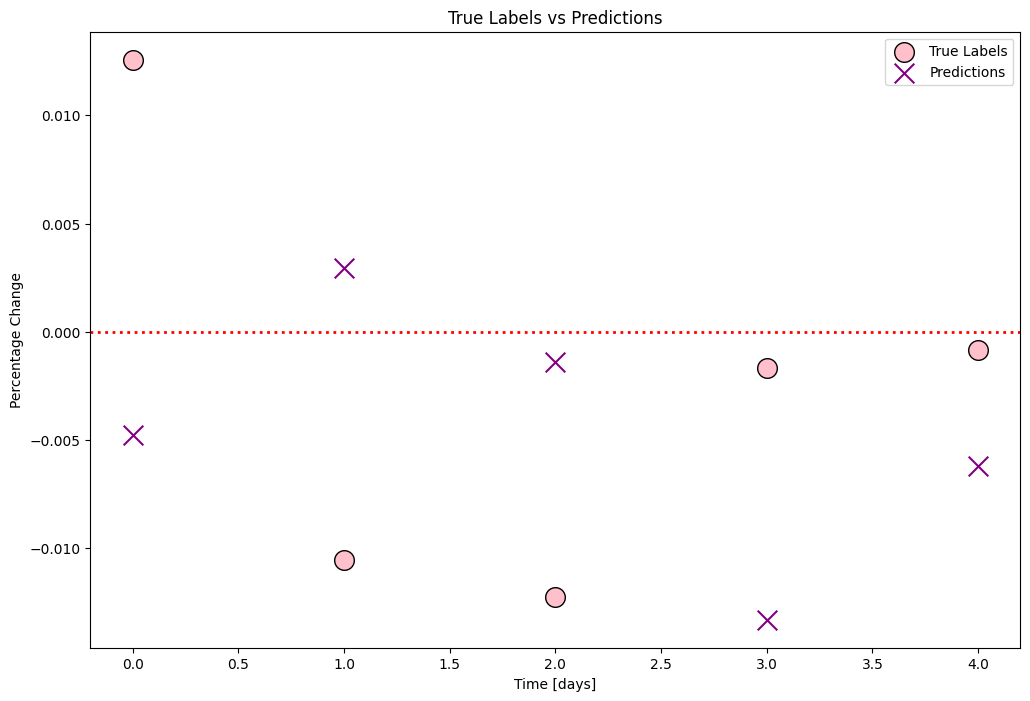

/tmp/ipykernel_5566/2140540707.py:13: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


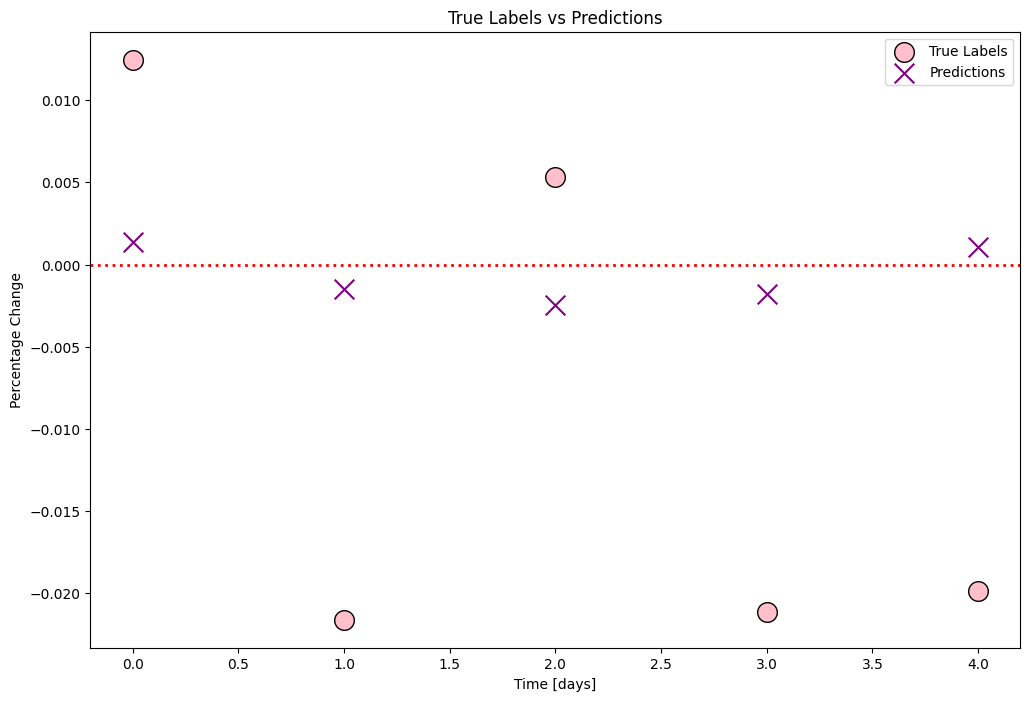

/tmp/ipykernel_5566/2140540707.py:13: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


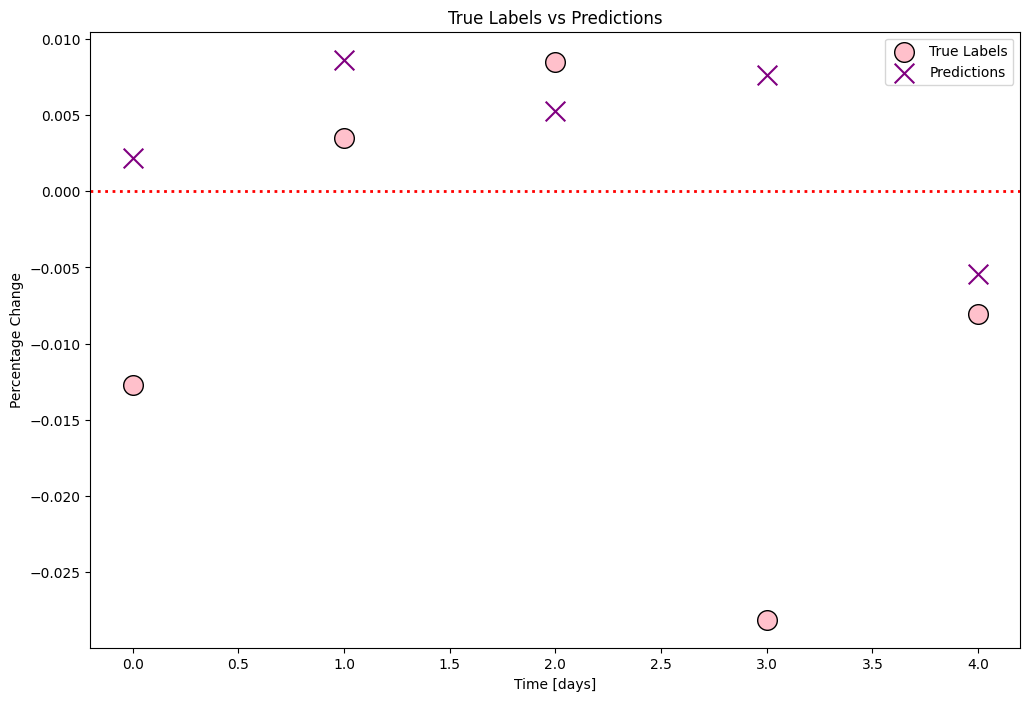

/tmp/ipykernel_5566/2140540707.py:13: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


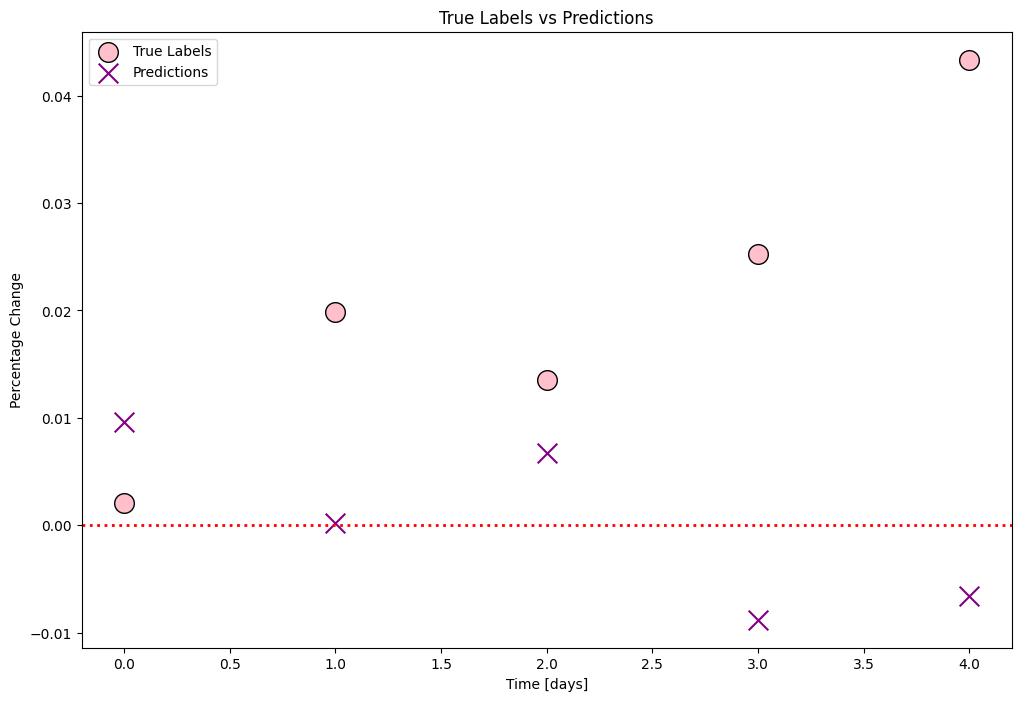

In [ ]:
for interval in intervals:
    model_file = f"model_{interval[0]}.pkl"
    start_date = str(df.index[interval[1]])
    end_date = str(df.index[interval[2]])

    X_test, y_test = get_test_data_for_ticker_by_index(df, ticker='HAL', test_start=interval[1], test_end=interval[2])
    #print(X_test)
    predictions = predict_xgb_2(X_test, 'HAL', model_file)
    true_labels = true_labels_xgb(y_test)
    plot_xgb_preds(X_test, predictions, true_labels)

---

### Visualizing the Results

Mean Error and Mean R²

In [ ]:
# Bar plot for mean_error and mean_r2
results_melted = results.melt(id_vars="ticker", value_vars=["mean_error", "mean_r2"], 
                              var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x="ticker", y="Value", hue="Metric")
plt.title("Mean Error and R² by Ticker")
plt.ylabel("Value")
plt.show()

AttributeError: 'list' object has no attribute 'melt'

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results["ticker"], results["mean_error"], yerr=results["std_error"], label="Mean Error", alpha=0.7)
plt.bar(results["ticker"], results["mean_r2"], yerr=results["std_r2"], label="Mean R²", alpha=0.7)
plt.legend()
plt.title("Mean Error and R² with Variability")
plt.show()

---

- Chang, V., Xu, Q.A., Chidozie, A. and Wang, H. (2024). Predicting Economic Trends and Stock Market Prices with Deep Learning and Advanced Machine Learning Techniques. Electronics, [online] 13(17), p.3396. doi:https://doi.org/10.3390/electronics13173396.

- Github.io. (2022). Time Series Cross Validation — forecast-tools. [online] Available at: https://tommonks.github.io/forecast-tools/content/03_cross_validation.html [Accessed 5 Dec. 2024].

- Sharma, N. (2024). How to Use XGBoost for Time-Series Forecasting? [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/.